In [ ]:
# # df = pd.read_csv('aggregated_hourly.csv')
# # #for every distinct device_id create a new column target with the value of WIFI shiftied by 1
# # df['target'] = 0
# # for i in df['device_id'].unique():
# #     df.loc[df['device_id'] == i, 'target'] = df.loc[df['device_id'] == i, 'WIFI'].shift(-1)
# # df.sort_values(by=['date_time'], inplace=True)
# # #drop
# # df = df.dropna()   
# # #onehot encode device_id into int
# # df = pd.get_dummies(df, columns=['device_id'], prefix = 'device_id')
# # #delete date_time column and device_id column
# # df = df.drop(columns=['date_time'])
# # df
# X = df.drop(columns=['target']).astype('float32')
# y = df['target'].astype('float32')
# X = torch.tensor(X.values).float()
# y = torch.tensor(y.values).float()
# print(X.shape)  
# print(y.shape)
# X_new = []
# window_size = 500
# #for i in range(0, len(X), window_size):
# for i in range(0, len(X)):
#     if i < window_size:
#         number_of_padding = window_size - i
#         padding = torch.zeros(number_of_padding, X.shape[1])
#         X_new.append(torch.cat((padding, X[:i])))
#     else:
#         X_new.append(X[i-window_size:i])
# X_new = torch.stack(X_new)
# X_new = X_new[1:]
# X_new.shape

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch 
import main.dataprep as dp

In [89]:
df = pd.read_csv('aggregated_hourly.csv')
a0 = ["hka-aqm-a017", "hka-aqm-a014"]
a1 = ["hka-aqm-a101", "hka-aqm-a102", "hka-aqm-a103", "hka-aqm-a106", "hka-aqm-a107", "hka-aqm-a108", "hka-aqm-a111", "hka-aqm-a112"]
df_cutoff = dp.cutoff_data(df, "2023-01-13", "2023-03-28")
df_cutoff = df.copy
df_cutoff = dp.cutoff_data(df, "2023-01-13", "2023-03-28")
df_mean = dp.build_lvl_df(df_cutoff, a1, ["tmp", "hum", "CO2", "VOC"], reset_ind= True)

In [90]:
X = df_mean.to_numpy()
y = df_mean["tmp"].shift(-1).to_numpy()
X_train, X_test, y_train, y_test = dp.train_test_split(X, y,train_size=0.95)
X_train_new, X_test_new = dp.format_tensor(X_train,window_size=200), dp.format_tensor(X_test,window_size=200)
y_train = y_train[:-1]#.unsqueeze(1)
y_test = y_test[:-1]#.unsqueeze(1)
X_train_new.shape, X_test_new.shape, y_train.shape, y_test.shape

(torch.Size([1685, 200, 4]),
 torch.Size([88, 200, 4]),
 torch.Size([1685]),
 torch.Size([88]))

In [91]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64

train_data = TensorDataset(X_train_new, y_train)
test_data = TensorDataset(X_test_new, y_test)

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [19]:
class PositionalEncoding(torch.nn.Module):
    """
    compute sinusoid encoding.
    """
    def __init__(self, d_model, max_len,device):
        """
        constructor of sinusoid encoding class

        :param d_model: dimension of model
        :param max_len: max sequence length
        :param device: hardware device setting
        """
        super(PositionalEncoding, self).__init__()

        # same size with input matrix (for adding with input matrix)
        self.encoding = torch.zeros(max_len, d_model, device=device)
        self.encoding.requires_grad = False  # we don't need to compute gradient
        pos = torch.arange(0, max_len,device=device)
        pos = pos.float().unsqueeze(dim=1)
        # # 1D => 2D unsqueeze to represent word's position

        _2i = torch.arange(0, d_model, step=2, device=device).float()
        # 'i' means index of d_model (e.g. embedding size = 50, 'i' = [0,50])
        # "step=2" means 'i' multiplied with two (same with 2 * i)

        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
        # compute positional encoding to consider positional information of words

    def forward(self, x):
        # self.encoding
        # [max_len = 512, d_model = 512]

        #batch_size, seq_len = x.size()
        # [batch_size = 128, seq_len = 30]

        return self.encoding
        #return self.encoding[:seq_len, :]
        # [seq_len = 30, d_model = 512]
        # it will add with tok_emb : [128, 30, 512]         

In [6]:
class ScaledDotProduct(torch.nn.Module):
    """
    scaled dot product attention class
    """
    def __init__(self):
        """
        constructor of scaled dot product attention class
        """
        super(ScaledDotProduct, self).__init__()
        
    def forward(self, Q, K, V, mask=None):
        """
        forward pass of scaled dot product attention
        :param Q: query tensor
        :param K: key tensor
        :param V: value tensor
        :param mask: mask tensor
        :return: output tensor
        """
        d_k = K.size(-1)
        # get dimension of key
        scores = (Q @ K.transpose(-2, -1)) / np.sqrt(d_k)
        # compute attention score
        # if mask is not None:
        #     scores = scores.masked_fill(mask == 0, -1e9)
        #     # apply mask to score
        attention = torch.nn.functional.softmax(scores, dim=-1)
        # apply softmax to score
        output = attention @ V
        # compute output tensor
        return output, attention

In [7]:
class MultiHeadAttention(torch.nn.Module):
    """
    multihead attention class
    """
    def __init__(self, d_model, num_heads):
        """
        constructor of multihead attention class

        :param d_model: dimension of model
        :param num_heads: number of head in multihead attention
        """
        super(MultiHeadAttention, self).__init__()

        self.d_model = d_model
        self.num_heads = num_heads

        self.d_k = d_model // num_heads
        # get dimension of key

        self.W_Q = torch.nn.Linear(d_model, d_model)
        self.W_K = torch.nn.Linear(d_model, d_model)
        self.W_V = torch.nn.Linear(d_model, d_model)
        # linear transformation for query, key, value

        self.scaled_dot_product = ScaledDotProduct()
        # scaled dot product attention

        self.linear = torch.nn.Linear(d_model, d_model)
        # linear transformation for output

    def forward(self, Q, K, V, mask=None):
        """
        forward pass of multihead attention

        :param Q: query tensor
        :param K: key tensor
        :param V: value tensor
        :param mask: mask tensor
        :return: output tensor
        """
        batch_size = Q.size(0)
        # get batch size

        Q = self.W_Q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_K(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_V(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        # linear transformation and split into multihead

        if mask is not None:
            mask = mask.unsqueeze(1)
            # unsqueeze mask

        output, attention = self.scaled_dot_product(Q, K, V, mask)
        # scaled dot product attention

        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        # concatenate multihead attention

        return self.linear(output), attention

In [92]:
class Decoder(torch.nn.Module):
    """
    decoder layer class
    """
    def __init__(self, input,d_model,max_len,num_heads,d_ff,device):
        """
        constructor of decoder layer

        :param d_model: dimension of model
        :param num_heads: number of head in multihead attention
        :param d_ff: dimension of feed forward layer
        :param dropout: dropout rate
        """
        super(Decoder, self).__init__()

        self.embed = torch.nn.Linear(input, d_model).to(device)
        self.positonal_encoding = PositionalEncoding(d_model, max_len=max_len,device=device).to(device)
        self.norm = torch.nn.LayerNorm(d_model).to(device)
        self.attn = MultiHeadAttention(d_model, num_heads).to(device)
        self.norm_2 = torch.nn.LayerNorm(d_model).to(device)
        self.linear1 = torch.nn.Linear(d_model, d_model).to(device)
        self.Relu = torch.nn.SELU().to(device)
        self.attn2 = MultiHeadAttention(d_model, num_heads).to(device)
        self.norm_3 = torch.nn.LayerNorm(d_model).to(device)
        self.linear2 = torch.nn.Linear(d_model, d_model).to(device)
        self.attn3 = MultiHeadAttention(d_model, num_heads).to(device)
        self.ff = torch.nn.Sequential(
            torch.nn.LayerNorm(d_model),
            torch.nn.Linear(d_model, d_ff),
            torch.nn.SELU(),
            torch.nn.Linear(d_ff, 1)
        ).to(device)

    def forward(self, x):
        """
        forward pass of decoder layer

        :param x: input tensor (query)
        :param memory: input tensor (key, value)
        :param src_mask: source mask
        :param tgt_mask: target mask
        :return: output tensor
        """
        x = self.embed(x)
        x = x + self.positonal_encoding(x)
        x_norm = self.norm(x)
        x_att, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + x_att
        x = self.norm_2(x)
        x_att2, _ = self.attn2(x, x, x)
        x_att2 = self.linear1(x_att2)
        x_att2 = self.Relu(x_att2)
        x = x + x_att2
        x = self.norm_3(x)
        x_att3, _ = self.attn3(x, x, x)
        x_att3 = self.linear2(x_att3)
        x_att3 = self.Relu(x_att3)
        x = x + x_att3
        x = self.ff(x) #shape am ende noch (500,1), soll des so ?
        return x[:, -1].squeeze()

In [9]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Decoder1 = Decoder(data[0][0].shape[1], 32,max_len=data[0][0].shape[0],num_heads=4,d_ff=128,device=device)
# d = Decoder1.forward(x)

In [93]:
# Train Decoder
from torch.optim import Adam
from torch.nn import MSELoss

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create a Decoder
Decoder1 = Decoder(train_data[0][0].shape[1], 128,max_len=train_data[0][0].shape[0],num_heads=4,d_ff=120,device=device)

# Create a Loss Function
criterion = MSELoss()

# Create an Optimizer
optimizer = Adam(Decoder1.parameters(), lr=0.001)

In [116]:
# Train the Decoder
import torch
import time

# Move model to GPU
Decoder1 = Decoder1.to(device)

# Define the number of epochs
num_epochs = 50

# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Decoder1.parameters(), lr=0.0005
)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.85)

Decoder1.train()
for epoch in range(num_epochs):
    for x, y in train_loader:
        # Move tensors to GPU
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        output = Decoder1(x)
        loss = criterion(output, y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Decay the learning rate
    scheduler.step()

    print(f'Epoch: {epoch + 1:03d}, Loss: {loss.item():.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.6f}')

Epoch: 001, Loss: 0.8593, Learning Rate: 0.000500
Epoch: 002, Loss: 0.2773, Learning Rate: 0.000425
Epoch: 003, Loss: 0.1564, Learning Rate: 0.000425
Epoch: 004, Loss: 0.4254, Learning Rate: 0.000361
Epoch: 005, Loss: 0.2012, Learning Rate: 0.000361
Epoch: 006, Loss: 0.1517, Learning Rate: 0.000307
Epoch: 007, Loss: 0.2815, Learning Rate: 0.000307
Epoch: 008, Loss: 0.2916, Learning Rate: 0.000261
Epoch: 009, Loss: 0.2196, Learning Rate: 0.000261
Epoch: 010, Loss: 0.1405, Learning Rate: 0.000222
Epoch: 011, Loss: 0.1452, Learning Rate: 0.000222
Epoch: 012, Loss: 0.2400, Learning Rate: 0.000189
Epoch: 013, Loss: 0.3949, Learning Rate: 0.000189
Epoch: 014, Loss: 0.3799, Learning Rate: 0.000160
Epoch: 015, Loss: 0.1994, Learning Rate: 0.000160
Epoch: 016, Loss: 0.2385, Learning Rate: 0.000136
Epoch: 017, Loss: 0.2339, Learning Rate: 0.000136
Epoch: 018, Loss: 0.1759, Learning Rate: 0.000116
Epoch: 019, Loss: 0.3078, Learning Rate: 0.000116
Epoch: 020, Loss: 0.2164, Learning Rate: 0.000098


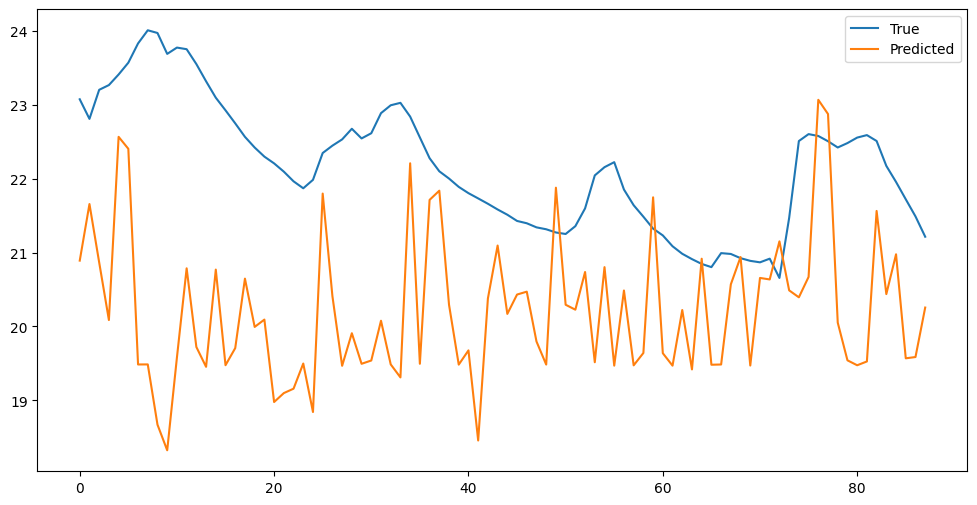

In [119]:
Decoder1.eval()
y_pred = []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        output = Decoder1(x)
        y_pred.append(output)

y_pred = torch.cat(y_pred, dim=0).cpu().numpy()
y_true = y_test.numpy()

plt.figure(figsize=(12, 6))
plt.plot(y_true, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [120]:
import numpy as np

# Assuming y_test and y_pred are numpy arrays
correlation = np.corrcoef(y_test, y_pred)[0, 1]
print("Correlation:", correlation)

Correlation: -0.012823753812436292


In [121]:
torch.save(Decoder1.state_dict(), 'DecoderSELU_Lookback200.pth')

In [28]:
x.shape

torch.Size([32, 500, 58])

In [188]:
data_loader

In [67]:
d_model = 512
num_heads = 8
multihead_attention = MultiHeadAttention(d_model, num_heads)


batch_size = 64
seq_len = 10
Q = torch.rand(batch_size, seq_len, d_model)
K = torch.rand(batch_size, seq_len, d_model)
V = torch.rand(batch_size, seq_len, d_model)
output, attention = multihead_attention(Q, K, V)

In [69]:
output.shape

torch.Size([64, 10, 512])

In [55]:

scaled_dot_product = ScaledDotProduct()
Q = torch.randn(10, 20, 30)
K = torch.randn(10, 20, 30)
V = torch.randn(10, 20, 40)


output, attention = scaled_dot_product(Q, K, V)

In [63]:
output[0].shape, attention[0].shape

(torch.Size([20, 40]), torch.Size([20, 20]))

In [64]:
attention[0][0]

tensor([0.0163, 0.0329, 0.0278, 0.1355, 0.0135, 0.0550, 0.0034, 0.0812, 0.0678,
        0.0717, 0.0605, 0.0011, 0.0840, 0.1410, 0.0687, 0.0337, 0.0112, 0.0352,
        0.0548, 0.0048])

In [46]:
Decoder = Decoder(data[0][0].shape[1], 25)

In [51]:
data[0][0]

tensor([[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
        [ 25.0800,  44.9700, -16.8000,  ...,   0.0000,   0.0000,   0.0000]])

In [52]:
Decoder.forward(data[0][0]).shape

torch.Size([500, 25])

In [56]:
class TransformerModel(torch.nn.Module):
    """
    Transformer model class
    """
    def __init__(self, input_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_len, device, src_pad_idx):
        """
        constructor of TransformerModel class

        :param input_size: input size
        :param d_model: dimension of model
        :param nhead: number of head
        :param num_encoder_layers: number of encoder layer
        :param dim_feedforward: dimension of feedforward
        :param max_len: max sequence length
        :param device: hardware device setting
        :param src_pad_idx: the index of the source padding token
        """
        super(TransformerModel, self).__init__()

        self.src_pad_idx = src_pad_idx
        self.embedding = torch.nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len, device)

        encoder_layer = torch.nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        encoder_norm = torch.nn.LayerNorm(d_model)
        self.transformer_encoder = torch.nn.TransformerEncoder(encoder_layer, num_encoder_layers, encoder_norm)

        self.fc = torch.nn.Linear(d_model, 1)

    def make_src_mask(self, src):
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        return src_mask

    def forward(self, src):
        """
        forward method

        :param src: source input
        :return: output
        """
        src_mask = self.make_src_mask(src)
        src = self.embedding(src)
        src = src + self.pos_encoder(src)

        output = self.transformer_encoder(src, src_key_padding_mask=src_mask.squeeze())
        output = self.fc(output)

        return output

In [53]:

d_model = 512
max_len = 1000
pe = PositonalEncoding(d_model, max_len)
x = torch.zeros((1, max_len, d_model))
output1 = pe.forward(x)
output1

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
           0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
           1.0366e-04,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
           2.0733e-04,  1.0000e+00],
         ...,
         [-8.9797e-01, -4.4006e-01,  4.2620e-01,  ...,  9.9427e-01,
           1.0317e-01,  9.9466e-01],
         [-8.5547e-01,  5.1785e-01,  9.8628e-01,  ...,  9.9425e-01,
           1.0327e-01,  9.9465e-01],
         [-2.6461e-02,  9.9965e-01,  6.9756e-01,  ...,  9.9424e-01,
           1.0337e-01,  9.9464e-01]]])